In [1]:
# Install required libraries
!pip install yfinance timesfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 416.6 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of googleapis-common-protos to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of transformers to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=21287bac6bf648c8fce14723a62dbac1d6c52c199a0e739912af6f09bbf2733c
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import os
import time
import timesfm
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [3]:
# Load TimesFM model
timesfm_backend = "gpu"  # or 'cpu'
from jax._src import config
config.update("jax_platforms", {"cpu": "cpu", "gpu": "cuda", "tpu": ""}[timesfm_backend])

In [4]:

model = timesfm.TimesFm(
    context_len=32,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

(…)oint_1100000/descriptor/descriptor.pbtxt:   0%|          | 0.00/499 [00:00<?, ?B/s]

(…)nts/checkpoint_1100000/metadata/metadata:   0%|          | 0.00/43.9k [00:00<?, ?B/s]

README.md:   0%|          | 0.00/5.73k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

checkpoint:   0%|          | 0.00/814M [00:00<?, ?B/s]

Constructing model weights.


Constructed model weights in 3.46 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 1.42 seconds.
Jitting decoding.
Jitted decoding in 23.21 seconds.


In [5]:
import ta
# Download stock data from Yahoo Finance
ticker = 'AAPL'  # Example: Apple Inc.
data = yf.download(ticker, start="2023-01-01", end="2024-01-01")

# Calculate moving averages
data['moving_avg_10'] = data['Close'].rolling(window=10).mean()
data['moving_avg_50'] = data['Close'].rolling(window=50).mean()
data['rsi'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()
data['ema'] = ta.trend.EMAIndicator(data['Close'], window=10).ema_indicator()

# Drop rows with NaN values (caused by rolling window calculations)
data = data.dropna()

df = data[['Close', 'Volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']].reset_index()
df.columns = ['date', 'close', 'volume', 'moving_avg_10', 'moving_avg_50', 'rsi', 'ema']
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

[*********************100%%**********************]  1 of 1 completed


,close,volume,moving_avg_10,moving_avg_50,rsi,ema
date,,,,,,
2023-03-15,152.990005,77167900,151.038000,144.793400,58.315418,151.047700
2023-03-16,155.850006,76161100,152.032001,145.409000,62.786074,151.920847
2023-03-17,155.000000,98944600,152.429001,145.981800,60.702342,152.480693
2023-03-20,157.399994,73641400,152.786000,146.629400,64.304515,153.375111
2023-03-21,159.279999,73938300,153.553999,147.222600,66.866621,154.448727
...,...,...,...,...,...,...
2023-12-22,193.600006,37122800,195.747002,185.398801,54.609714,194.957922
2023-12-26,193.050003,28919300,195.734003,185.682801,53.026884,194.611027
2023-12-27,193.149994,48087700,195.578001,185.971400,53.291939,194.345385


In [6]:


def get_batched_data_fn(batch_size: int = 32, context_len: int = 32, horizon_len: int = 1):
    examples = defaultdict(list)
    num_examples = 0
    for start in range(0, len(df) - (context_len + horizon_len), horizon_len):
        num_examples += 1
        context_end = start + context_len
        examples["inputs"].append(df["close"][start:context_end].tolist())
        examples["volume"].append(df["volume"][start:context_end].tolist() + [df["volume"].iloc[context_end - 1]])
        examples["moving_avg_10"].append(df["moving_avg_10"][start:context_end].tolist() + [df["moving_avg_10"].iloc[context_end - 1]])
        examples["moving_avg_50"].append(df["moving_avg_50"][start:context_end].tolist() + [df["moving_avg_50"].iloc[context_end - 1]])
        examples["rsi"].append(df["rsi"][start:context_end].tolist() + [df["rsi"].iloc[context_end - 1]])
        examples["ema"].append(df["ema"][start:context_end].tolist() + [df["ema"].iloc[context_end - 1]])
        examples["outputs"].append(df["close"][context_end:context_end + horizon_len].tolist())
        examples["dates"].append(df.index[start:context_end + horizon_len].tolist())  # Add dates to examples

    def data_fn():
        for i in range(1 + (num_examples - 1) // batch_size):
            yield {k: v[(i * batch_size): ((i + 1) * batch_size)] for k, v in examples.items()}

    return data_fn

In [7]:


# Define metrics
def mse(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.square(y_pred - y_true), axis=1, keepdims=True)

def mae(y_pred, y_true):
    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    return np.mean(np.abs(y_pred - y_true), axis=1, keepdims=True)

In [23]:
import timesfm
model = timesfm.TimesFm(
    context_len=64,
    horizon_len=1,
    input_patch_len=32,
    output_patch_len=128,
    num_layers=20,
    model_dims=1280,
    backend=timesfm_backend,
)
model.load_from_checkpoint(repo_id="google/timesfm-1.0-200m")


Multiprocessing context has already been set.


Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

Constructing model weights.


Constructed model weights in 4.39 seconds.
Restoring checkpoint from /root/.cache/huggingface/hub/models--google--timesfm-1.0-200m/snapshots/8775f7531211ac864b739fe776b0b255c277e2be/checkpoints.


ERROR:absl:For checkpoint version > 1.0, we require users to provide
          `train_state_unpadded_shape_dtype_struct` during checkpoint
          saving/restoring, to avoid potential silent bugs when loading
          checkpoints to incompatible unpadded shapes of TrainState.


Restored checkpoint in 0.63 seconds.
Jitting decoding.
Jitted decoding in 18.41 seconds.


In [25]:
import os
import time
from collections import defaultdict
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import timesfm
import ta
from itertools import combinations


features = ["volume", "moving_avg_10", "moving_avg_50", "rsi", "ema"]
feature_combinations = []
for r in range(1, len(features) + 1):
    feature_combinations.extend(combinations(features, r))

# نتایج برای اندازه‌های مختلف دسته و دو حالت مختلف
batch_sizes = range(1, 34, 5)
results_summary_all = []
best_results_summary = []

for batch_size in batch_sizes:
    for reverse in [False, True]:
        xreg_mode = "xreg + timesfm" if reverse else "timesfm + xreg"
        print(f"Testing batch size: {batch_size}, mode: {xreg_mode}")

        # Benchmark
        context_len = 33
        horizon_len = 1

        results_summary = []

        for combo in feature_combinations:
            input_data = get_batched_data_fn(batch_size=batch_size, context_len=context_len, horizon_len=horizon_len)
            metrics = defaultdict(list)
            results = []

            for i, example in enumerate(input_data()):

                raw_forecast, _ = model.forecast(
                    inputs=example["inputs"], freq=[0] * len(example["inputs"])
                )
                start_time = time.time()


                dynamic_numerical_covariates = {feature: example[feature] for feature in combo}


                # Forecast with covariates
                cov_forecast, ols_forecast = model.forecast_with_covariates(
                    inputs=example["inputs"],
                    dynamic_numerical_covariates=dynamic_numerical_covariates,
                    dynamic_categorical_covariates={},
                    static_numerical_covariates={},
                    static_categorical_covariates={},
                    freq=[0] * len(example["inputs"]),


                    normalize_xreg_target_per_input=True,
                    xreg_mode=xreg_mode,
                )
                end_time = time.time()

                for j in range(len(example["inputs"])):
                    result = {
                        'batch': i,
                        'input_index': j,
                        'train_start_date': example["dates"][j][0],  # Start date of the training data
                        'train_end_date': example["dates"][j][-2],  # End date of the training data
                        'predict_date': example["dates"][j][-1],  # Prediction date
                        'raw_forecast': raw_forecast[j][0],
                        'y_actual': example["outputs"][j][0],
                        'y_predicted': cov_forecast[j][0],
                        'features': str(combo),
                        'batch_size': batch_size,
                        'reverse': reverse,
                        'xreg_mode': xreg_mode
                    }
                    results.append(result)

            results_df = pd.DataFrame(results)

            # Calculate accuracy
            correct_predictions = 0
            total_predictions = 0

            for i in range(1, len(results_df)):
                actual_today = results_df.iloc[i]['y_actual']
                predicted_today = results_df.iloc[i]['y_predicted']
                actual_yesterday_index = i - 1
                actual_yesterday_date = results_df.iloc[actual_yesterday_index]['predict_date']

                if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['predict_date']) - pd.DateOffset(days=1):
                    continue

                actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']
                actual_movement = actual_today - actual_yesterday
                predicted_movement = predicted_today - actual_yesterday

                if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
                    correct_predictions += 1

                total_predictions += 1

            accuracy = correct_predictions / total_predictions

            # Calculate profit
            results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')
            initial_investment = 100
            capital = initial_investment
            shares = 0
            profit = 0
            capital_history = []

            for i in range(len(results_df) - 1):
                i = i + 1
                if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
                    shares = capital / results_df.loc[i, 'y_actual']
                    capital = 0
                elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:
                    capital = shares * results_df.loc[i, 'y_actual']
                    shares = 0
                capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

            final_capital = capital + shares * results_df.iloc[-1]['y_actual']
            total_profit = final_capital - initial_investment

            results_summary.append({
                'features': combo,
                'mse_model': mean_squared_error(results_df['y_actual'], results_df['y_predicted']),
                'mse_naive': mean_squared_error(results_df['y_actual'], results_df['raw_forecast']),
                'accuracy': accuracy,
                'profit': total_profit,
                'batch_size': batch_size,
                'reverse': reverse,
                'xreg_mode': xreg_mode,
                'results_df': results_df
            })

        # اضافه کردن نتایج به لیست کلی
        results_summary_all.extend(results_summary)

        # پیدا کردن بهترین نتایج برای این اندازه دسته
        best_mse_model = min(results_summary, key=lambda x: x['mse_model'])
        best_accuracy = max(results_summary, key=lambda x: x['accuracy'])
        best_profit = max(results_summary, key=lambda x: x['profit'])

        best_results_summary.append({
            'best_by_mse': best_mse_model,
            'best_by_accuracy': best_accuracy,
            'best_by_profit': best_profit,
            'batch_size': batch_size,
            'reverse': reverse,
            'xreg_mode': xreg_mode
        })



Testing batch size: 1, mode: timesfm + xreg
Testing batch size: 1, mode: xreg + timesfm
Testing batch size: 6, mode: timesfm + xreg
Testing batch size: 6, mode: xreg + timesfm
Testing batch size: 11, mode: timesfm + xreg
Testing batch size: 11, mode: xreg + timesfm
Testing batch size: 16, mode: timesfm + xreg
Testing batch size: 16, mode: xreg + timesfm
Testing batch size: 21, mode: timesfm + xreg
Testing batch size: 21, mode: xreg + timesfm
Testing batch size: 26, mode: timesfm + xreg
Testing batch size: 26, mode: xreg + timesfm
Testing batch size: 31, mode: timesfm + xreg
Testing batch size: 31, mode: xreg + timesfm


In [26]:
best_results_summary

[{'best_by_mse': {'features': ('volume',),
   'mse_model': 41.42994851801924,
   'mse_naive': 5.722619830998787,
   'accuracy': 0.5230769230769231,
   'profit': 8.76756404240885,
   'batch_size': 1,
   'reverse': False,
   'xreg_mode': 'timesfm + xreg',
   'results_df':      batch  input_index train_start_date train_end_date predict_date  \
   0        0            0       2023-03-15     2023-05-01   2023-05-02   
   1        1            0       2023-03-16     2023-05-02   2023-05-03   
   2        2            0       2023-03-17     2023-05-03   2023-05-04   
   3        3            0       2023-03-20     2023-05-04   2023-05-05   
   4        4            0       2023-03-21     2023-05-05   2023-05-08   
   ..     ...          ...              ...            ...          ...   
   162    162            0       2023-11-03     2023-12-20   2023-12-21   
   163    163            0       2023-11-06     2023-12-21   2023-12-22   
   164    164            0       2023-11-07     2023-12-2

In [28]:
# تبدیل نتایج به دیتافریم
results_df_all = pd.DataFrame(results_summary_all)

# پیدا کردن بهترین MSE، دقت و سود برای هر اندازه دسته
best_mse_per_batch = results_df_all.loc[results_df_all.groupby('batch_size')['mse_model'].idxmin()]
best_accuracy_per_batch = results_df_all.loc[results_df_all.groupby('batch_size')['accuracy'].idxmax()]
best_profit_per_batch = results_df_all.loc[results_df_all.groupby('batch_size')['profit'].idxmax()]

# نمایش نتایج به شکل جدول مرتب
def display_best_results(df, metric):
    print(f"\nBest {metric} per Batch Size:")
    print(df[['batch_size', 'features', 'mse_model', 'accuracy', 'profit', 'reverse', 'xreg_mode']].to_string(index=False))

display_best_results(best_mse_per_batch, 'MSE')
display_best_results(best_accuracy_per_batch, 'Accuracy')
display_best_results(best_profit_per_batch, 'Profit')



Best MSE per Batch Size:
 batch_size                                    features  mse_model  accuracy    profit  reverse      xreg_mode
          1 (volume, moving_avg_10, moving_avg_50, rsi)   4.570031  0.507692 12.002480     True xreg + timesfm
          6         (moving_avg_10, moving_avg_50, rsi)   4.647352  0.538462 11.874051     True xreg + timesfm
         11         (moving_avg_10, moving_avg_50, rsi)   4.597954  0.492308 14.905904     True xreg + timesfm
         16                   (moving_avg_50, rsi, ema)   4.758693  0.400000 11.822021     True xreg + timesfm
         21         (moving_avg_10, moving_avg_50, rsi)   4.558581  0.453846 11.193148     True xreg + timesfm
         26                   (moving_avg_10, rsi, ema)   4.721913  0.469231 11.250757     True xreg + timesfm
         31                                  (rsi, ema)   4.688122  0.438462 17.148908     True xreg + timesfm

Best Accuracy per Batch Size:
 batch_size                            features  mse_mo

In [32]:
results_xreg_timesfm = results_df_all[results_df_all['xreg_mode'] == 'xreg + timesfm']
results_timesfm_xreg = results_df_all[results_df_all['xreg_mode'] == 'timesfm + xreg']


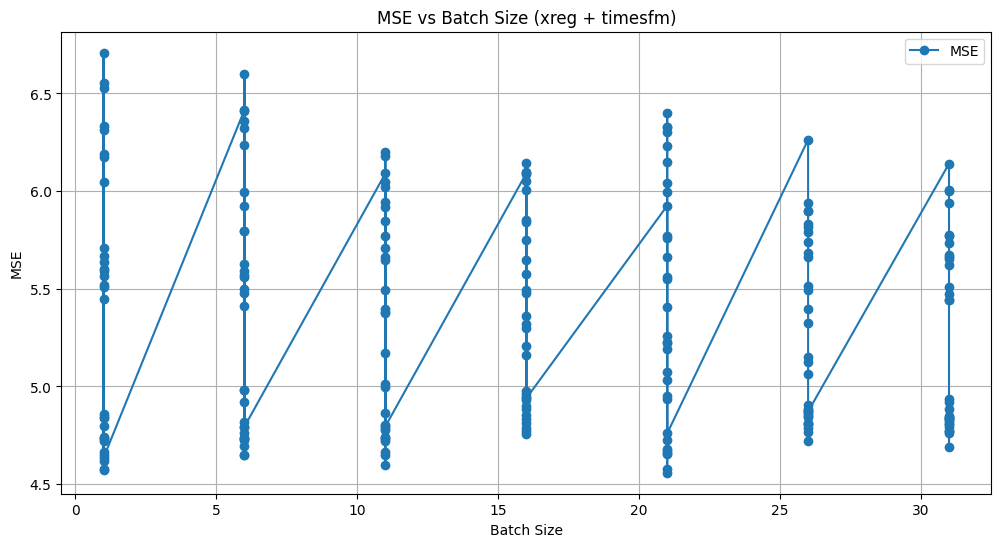

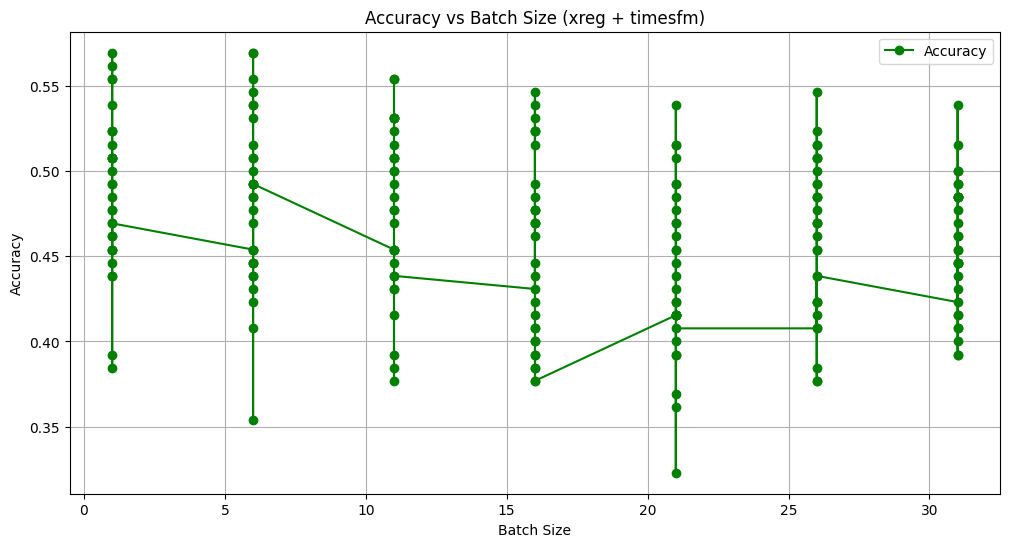

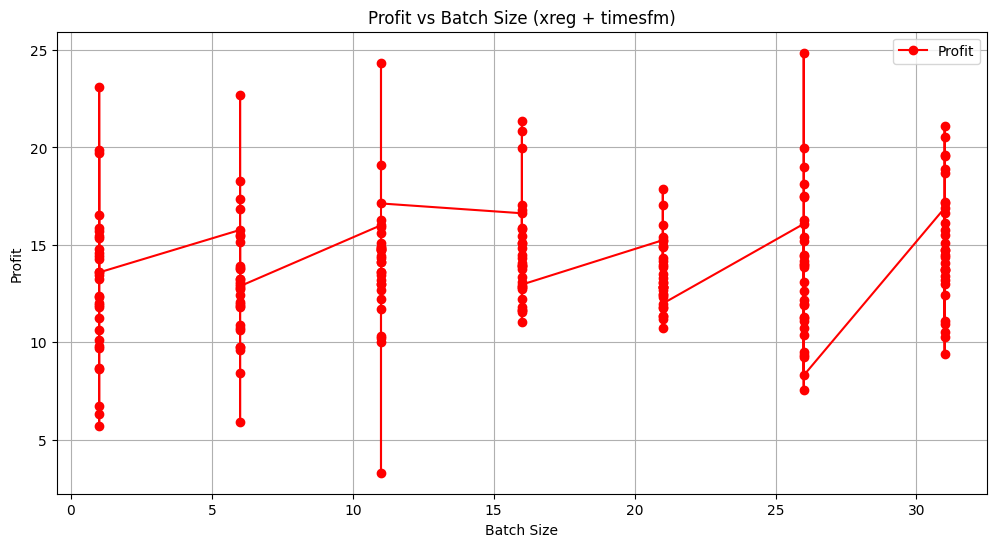

In [33]:
# تغییرات MSE با اندازه دسته برای حالت xreg + timesfm
plt.figure(figsize=(12, 6))
plt.plot(results_xreg_timesfm['batch_size'], results_xreg_timesfm['mse_model'], marker='o', label='MSE')
plt.xlabel('Batch Size')
plt.ylabel('MSE')
plt.title('MSE vs Batch Size (xreg + timesfm)')
plt.legend()
plt.grid(True)
plt.show()

# تغییرات دقت با اندازه دسته برای حالت xreg + timesfm
plt.figure(figsize=(12, 6))
plt.plot(results_xreg_timesfm['batch_size'], results_xreg_timesfm['accuracy'], marker='o', label='Accuracy', color='green')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size (xreg + timesfm)')
plt.legend()
plt.grid(True)
plt.show()

# تغییرات سود با اندازه دسته برای حالت xreg + timesfm
plt.figure(figsize=(12, 6))
plt.plot(results_xreg_timesfm['batch_size'], results_xreg_timesfm['profit'], marker='o', label='Profit', color='red')
plt.xlabel('Batch Size')
plt.ylabel('Profit')
plt.title('Profit vs Batch Size (xreg + timesfm)')
plt.legend()
plt.grid(True)
plt.show()


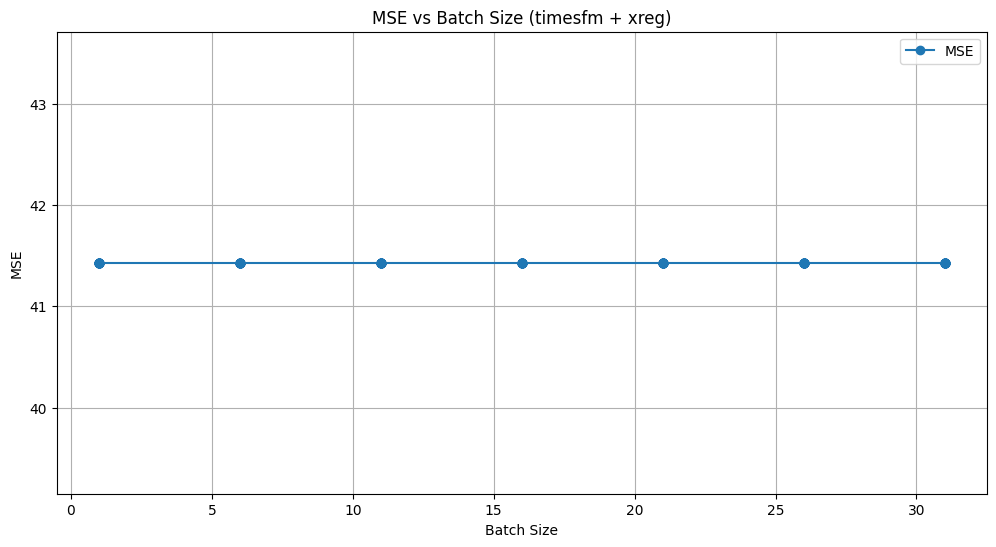

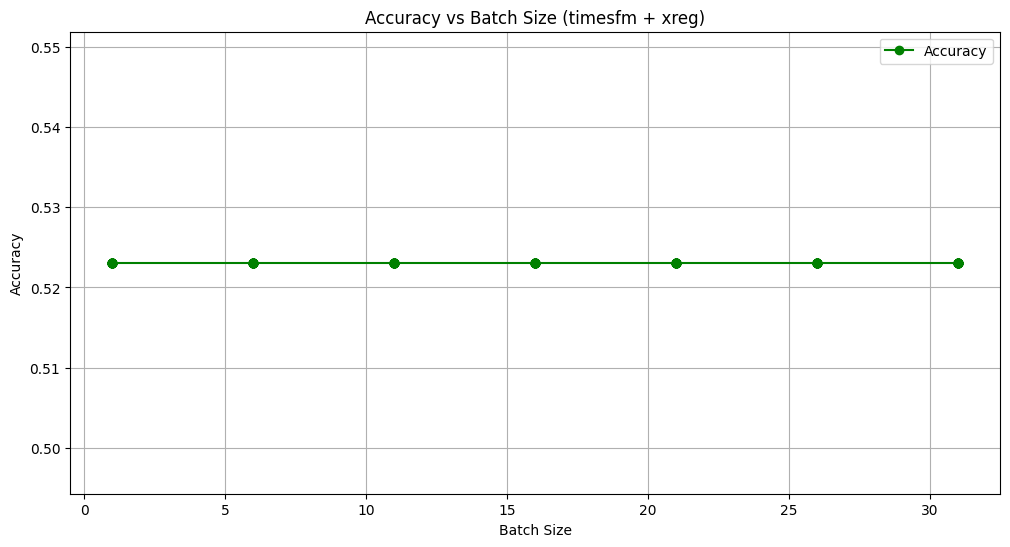

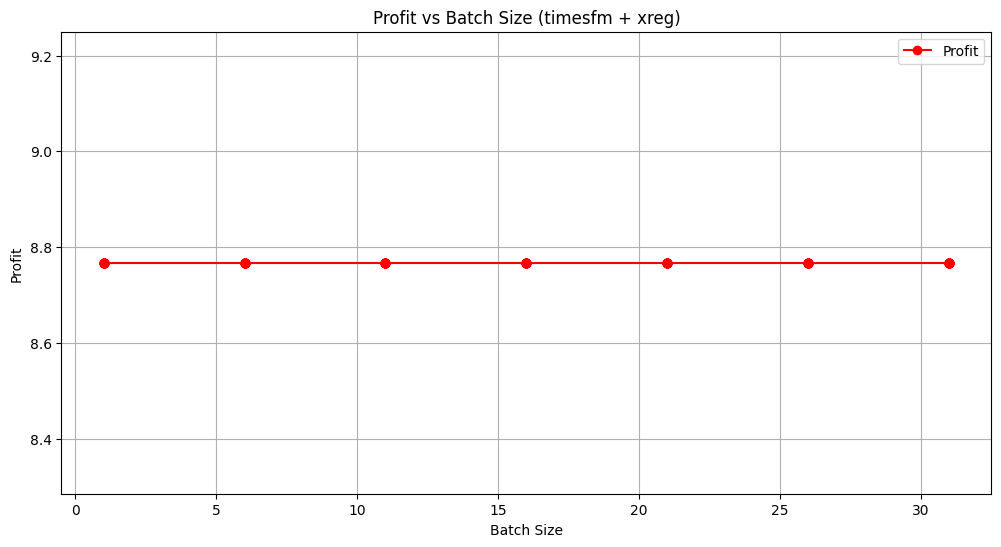

In [34]:
# تغییرات MSE با اندازه دسته برای حالت timesfm + xreg
plt.figure(figsize=(12, 6))
plt.plot(results_timesfm_xreg['batch_size'], results_timesfm_xreg['mse_model'], marker='o', label='MSE')
plt.xlabel('Batch Size')
plt.ylabel('MSE')
plt.title('MSE vs Batch Size (timesfm + xreg)')
plt.legend()
plt.grid(True)
plt.show()

# تغییرات دقت با اندازه دسته برای حالت timesfm + xreg
plt.figure(figsize=(12, 6))
plt.plot(results_timesfm_xreg['batch_size'], results_timesfm_xreg['accuracy'], marker='o', label='Accuracy', color='green')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size (timesfm + xreg)')
plt.legend()
plt.grid(True)
plt.show()

# تغییرات سود با اندازه دسته برای حالت timesfm + xreg
plt.figure(figsize=(12, 6))
plt.plot(results_timesfm_xreg['batch_size'], results_timesfm_xreg['profit'], marker='o', label='Profit', color='red')
plt.xlabel('Batch Size')
plt.ylabel('Profit')
plt.title('Profit vs Batch Size (timesfm + xreg)')
plt.legend()
plt.grid(True)
plt.show()


In [30]:
# buy_and_hold_profit
initial_investment = 100
buy_and_hold_final_value = initial_investment * (results_df['y_actual'].iloc[-1] / results_df['y_actual'].iloc[0])
buy_and_hold_profit = buy_and_hold_final_value - initial_investment
buy_and_hold_profit

14.857012900440239

In [31]:
best_mse = results_df_all.loc[results_df_all['mse_model'].idxmin()]
best_accuracy = results_df_all.loc[results_df_all['accuracy'].idxmax()]
best_profit = results_df_all.loc[results_df_all['profit'].idxmax()]

print("Best MSE:")
print(best_mse)
print("\nBest Accuracy:")
print(best_accuracy)
print("\nBest Profit:")
print(best_profit)

Best MSE:
features                    (moving_avg_10, moving_avg_50, rsi)
mse_model                                              4.558581
mse_naive                                               5.72262
accuracy                                               0.453846
profit                                                11.193148
batch_size                                                   21
reverse                                                    True
xreg_mode                                        xreg + timesfm
results_df         batch  input_index train_start_date train...
Name: 300, dtype: object

Best Accuracy:
features                    (moving_avg_10, moving_avg_50, rsi)
mse_model                                              4.579252
mse_naive                                               5.72262
accuracy                                               0.569231
profit                                                11.824151
batch_size                                           

In [40]:
results_df

,batch,input_index,train_start_date,train_end_date,predict_date,raw_forecast,y_actual,y_predicted,features,batch_size,reverse,xreg_mode,signal
0,0,0,2023-03-15,2023-05-01,2023-05-02,168.012299,168.539993,169.660522,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Buy
1,0,1,2023-03-16,2023-05-02,2023-05-03,168.021179,167.449997,168.662872,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Sell
2,0,2,2023-03-17,2023-05-03,2023-05-04,166.908066,165.789993,167.367020,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Sell
3,0,3,2023-03-20,2023-05-04,2023-05-05,165.397537,173.570007,165.688721,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Buy
4,0,4,2023-03-21,2023-05-05,2023-05-08,170.445740,173.500000,172.742859,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Buy
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,5,7,2023-11-03,2023-12-20,2023-12-21,197.500259,194.679993,194.971008,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Sell
163,5,8,2023-11-06,2023-12-21,2023-12-22,195.799637,193.600006,194.737747,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Sell
164,5,9,2023-11-07,2023-12-22,2023-12-26,194.166153,193.050003,193.595413,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Sell
165,5,10,2023-11-08,2023-12-26,2023-12-27,192.712112,193.149994,193.094101,"('volume', 'moving_avg_10', 'moving_avg_50', '...",31,True,xreg + timesfm,Buy


In [50]:
def calculate_raw_metrics(results):

            correct_predictions = 0
            total_predictions = 0

            for i in range(1, len(results_df)):
                actual_today = results_df.iloc[i]['y_actual']
                predicted_today = results_df.iloc[i]['y_predicted']
                actual_yesterday_index = i - 1
                actual_yesterday_date = results_df.iloc[actual_yesterday_index]['predict_date']

                if pd.to_datetime(actual_yesterday_date) != pd.to_datetime(results_df.iloc[i]['predict_date']) - pd.DateOffset(days=1):
                    continue

                actual_yesterday = results_df.iloc[actual_yesterday_index]['y_actual']
                actual_movement = actual_today - actual_yesterday
                predicted_movement = predicted_today - actual_yesterday

                if (actual_movement > 0 and predicted_movement > 0) or (actual_movement < 0 and predicted_movement < 0):
                    correct_predictions += 1

                total_predictions += 1

            accuracy = correct_predictions / total_predictions

            # Calculate profit
            results_df['signal'] = np.where(results_df['y_predicted'].shift(-1) > results_df['y_predicted'], 'Buy', 'Sell')
            initial_investment = 100
            capital = initial_investment
            shares = 0
            profit = 0
            capital_history = []

            for i in range(len(results_df) - 1):
                i = i + 1
                if results_df.loc[i, 'signal'] == 'Buy' and capital > 0:
                    shares = capital / results_df.loc[i, 'y_actual']
                    capital = 0
                elif results_df.loc[i, 'signal'] == 'Sell' and shares > 0:
                    capital = shares * results_df.loc[i, 'y_actual']
                    shares = 0
                capital_history.append(capital + shares * results_df.loc[i, 'y_actual'])

            final_capital = capital + shares * results_df.iloc[-1]['y_actual']
            total_profit = final_capital - initial_investment


            return  mean_squared_error(results_df['y_actual'], results_df['raw_forecast']), accuracy, total_profit

# محاسبه معیارها به ازای اندازه دسته‌های مختلف
batch_sizes = results_df_all['batch_size'].unique()
raw_metrics_summary = []

for batch_size in batch_sizes:
    results_batch = results_df_all[results_df_all['batch_size'] == batch_size]
    mse_raw, accuracy_raw, profit_raw = calculate_raw_metrics(results_batch['results_df'])
    raw_metrics_summary.append({
        'batch_size': batch_size,
        'mse_raw': mse_raw,
        'accuracy_raw': accuracy_raw,
        'profit_raw': profit_raw
    })

raw_metrics_summary_df = pd.DataFrame(raw_metrics_summary)


In [52]:
raw_metrics_summary

[{'batch_size': 1,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 6,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 11,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 16,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 21,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 26,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053},
 {'batch_size': 31,
  'mse_raw': 5.722619830998787,
  'accuracy_raw': 0.46153846153846156,
  'profit_raw': 10.917962652413053}]

In [53]:
# پیدا کردن بهترین MSE، دقت و سود برای هر اندازه دسته
best_mse = raw_metrics_summary_df.loc[raw_metrics_summary_df['mse_raw'].idxmin()]
best_accuracy = raw_metrics_summary_df.loc[raw_metrics_summary_df['accuracy_raw'].idxmax()]
best_profit = raw_metrics_summary_df.loc[raw_metrics_summary_df['profit_raw'].idxmax()]

print("Best MSE:")
print(best_mse)
print("\nBest Accuracy:")
print(best_accuracy)
print("\nBest Profit:")
print(best_profit)


Best MSE:
batch_size       1.000000
mse_raw          5.722620
accuracy_raw     0.461538
profit_raw      10.917963
Name: 0, dtype: float64

Best Accuracy:
batch_size       1.000000
mse_raw          5.722620
accuracy_raw     0.461538
profit_raw      10.917963
Name: 0, dtype: float64

Best Profit:
batch_size       1.000000
mse_raw          5.722620
accuracy_raw     0.461538
profit_raw      10.917963
Name: 0, dtype: float64
